In [1]:
import sys
sys.path.insert(0, '../code/')
from dismod_db import DismodDB
from two_level import TwoLevel
from plot_two_level import PlotTwoLevel
import numpy as np
import pandas as pd
from dismod_output import DismodOutput

#### Build database

In [2]:
data = pd.read_csv('./data/diabetes_sinc_complete_loc.csv')

In [3]:
data.head()

,Unnamed: 0,location_id,X,sex,age_start,age_end,year_start,year_end,mean,standard_error,measure,ow,bmi,fpg,location_name,region_name
0,1,8,855,Female,30,44.0,2001,2002,0.000025,0.0001,Sincidence,0.271136,23.525415,5.100081,Taiwan,East Asia
1,2,8,859,Male,45,59.0,2007,2008,0.000005,0.0001,Sincidence,0.538278,24.704975,5.562921,Taiwan,East Asia
2,3,8,879,Female,30,44.0,2007,2008,0.000017,0.0001,Sincidence,0.306358,24.154000,5.032846,Taiwan,East Asia
3,4,8,883,Female,0,14.0,2003,2004,0.000058,0.0001,Sincidence,0.181352,23.763450,0.000000,Taiwan,East Asia
4,5,8,857,Female,0,14.0,2005,2006,0.000055,0.0001,Sincidence,0.184948,23.969006,0.000000,Taiwan,East Asia


In [35]:
integrand = ['Sincidence']
locations = ['Australia', 'New Zealand']
rates = ['iota']
meas_noise_density = {'Sincidence': {'density': 'gaussian'}}
rates_parent_priors = [
    # rate priors for iota
    ({'density':'uniform','upper':1.0,'lower':1e-16,'mean': .0001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001})]
rates_child_priors = [({'density':'gaussian','mean': 0.0, 'std': .1}, None, None)]
covariates = [{'name':'bmi','type': 'rate_value','effected': 'iota'},
             {'name': 'ow', 'type': 'rate_value', 'effected': 'iota'}]
cov_priors = [{'density':'uniform','mean': 0.0, 'lower': -0.1, 'upper': 0.1}, 
              {'density':'uniform','mean': 0.0, 'lower': -10.0, 'upper': 10.0}]
#---------change path------------
path_to_db = './data/incidence_two_level_cov_2.db'

db = DismodDB(data, locations, integrand,rates, rates_parent_priors, 
              rates_child_priors, meas_noise_density, path_to_db, covariates=covariates, cov_priors=cov_priors)

#### Train model

In [36]:
model = TwoLevel(db)

In [37]:
model.fit_both(tol=1e-8, max_iter=200, fit_fixed=False)

/home/prefix/dismod_at.release/bin/dismod_at ./data/incidence_two_level_cov_2.db init
./data/incidence_two_level_cov_2.db fit both
./data/incidence_two_level_cov_2.db predict fit_var


#### Plots

In [38]:
path = './data/'
plt = PlotTwoLevel(path, 'incidence_two_level_cov_2.db')

{1: 'Australia', 2: 'New Zealand', 0: 'all'}


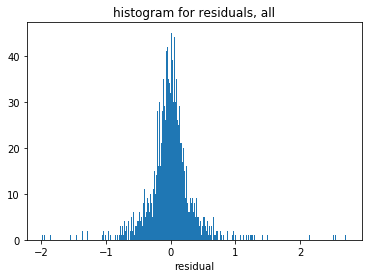

In [39]:
plt.plot_residuals('all')

In [40]:
output = DismodOutput(path_to_db)
output.get_covariate_multiplier_values(['bmi', 'ow'])

{1: 'Australia', 2: 'New Zealand', 0: 'all'}


,covariate_name,fit_var_value
2,bmi,-0.013516
3,ow,2.033249


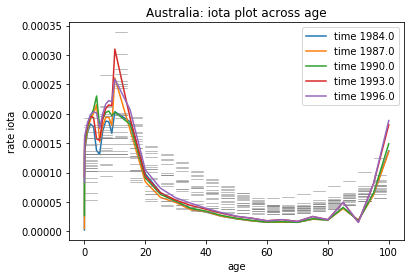

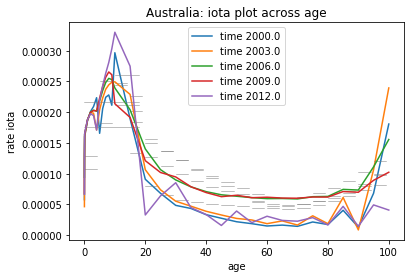

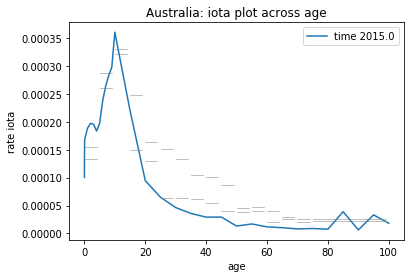

In [41]:
plt.plot_change_over_age('rate', 'iota', 'Sincidence', 'Australia')

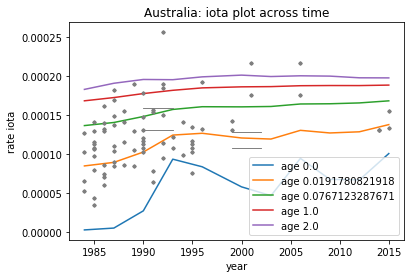

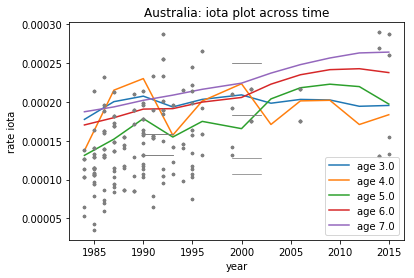

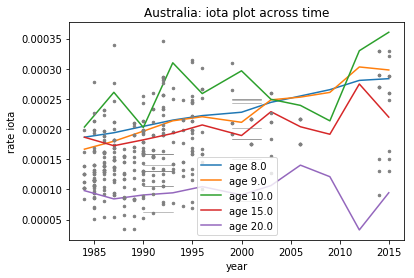

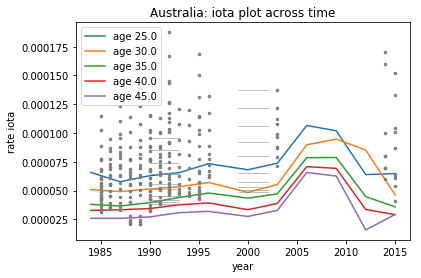

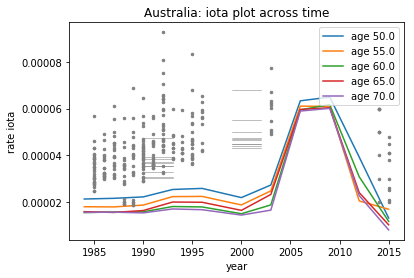

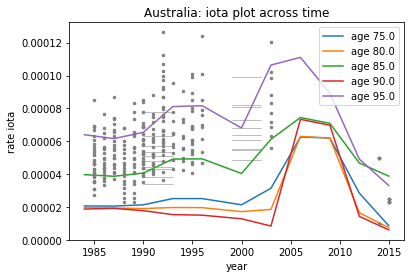

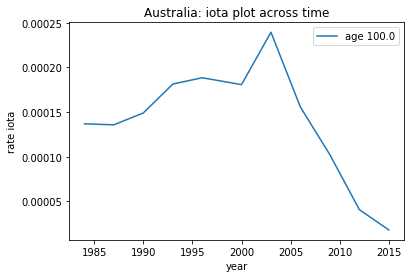

In [42]:
plt.plot_change_over_time('rate', 'iota', 'Sincidence', 'Australia')

#### Compute GBD output

In [6]:
output = DismodOutput(path_to_db)
bmi = pd.read_csv('./data/bmi.csv')
ow = pd.read_csv('./data/overweight.csv')
cov_dfs = {"bmi": bmi, "ow": ow}
integrand = ['Sincidence']
locations = ['Australia', 'New Zealand']
location_name_to_id = {}
for i, row in data[data['location_name'].isin(locations)].iterrows():
    location_name_to_id[row['location_name']] = row['location_id']
    if len(location_name_to_id) == len(locations):
        break
print(location_name_to_id)
output.save_GBD_output(['Sincidence', 'prevalence'], 395838, [2000], [1], 
                       location_name_to_id, './data/incidence_gbd_cov_sample.csv',
                      covariates=cov_dfs)

{1: 'Australia', 2: 'New Zealand', 0: 'all'}
{'Australia': 71, 'New Zealand': 72}
./data/incidence_two_level_cov_2_gbd.db
./data/incidence_two_level_cov_2_gbd.db predict fit_var
(88, 23) (88, 9)


In [7]:
df = pd.read_csv('./data/incidence_gbd_cov_sample.csv')

In [12]:
df.head()

,Unnamed: 0,node_name,integrand_name,avgint_id,integrand_id,node_id,weight_id,age_lower,age_upper,time_lower,...,measure_id,sex_id,x_0,x_1,x_2,x_3,mean,lower,upper,model_version_id
0,0,Australia,Sincidence,0,0,1,NaN,0.000000,0.019178,2000.0,...,6,1,NaN,NaN,27.041217,0.0,0.000130,0.000130,0.000130,395838
1,1,New Zealand,Sincidence,1,0,2,NaN,0.000000,0.019178,2000.0,...,6,1,NaN,NaN,27.077786,0.0,0.000128,0.000128,0.000128,395838
2,2,Australia,Sincidence,2,0,1,NaN,0.019178,0.076712,2000.0,...,6,1,NaN,NaN,27.041217,0.0,0.000142,0.000142,0.000142,395838
3,3,New Zealand,Sincidence,3,0,2,NaN,0.019178,0.076712,2000.0,...,6,1,NaN,NaN,27.077786,0.0,0.000140,0.000140,0.000140,395838
4,4,Australia,Sincidence,4,0,1,NaN,0.076712,1.000000,2000.0,...,6,1,NaN,NaN,27.041217,0.0,0.000151,0.000151,0.000151,395838
